In [1]:
#run this to install dependencies
!pip install netrd
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 78.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of numpydoc to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=38a6547fb4fbe214a99cdf62fc96aa1eba0a271f88fb601c39574208cc7d6422
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
#all necessary imports here
import torch_geometric.datasets
import torch_geometric.data
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import netrd
from scipy.sparse import csr_matrix, lil_matrix

In [3]:
def plot_degree_dist(G, n = 'Custom'):
  degrees = [G.degree(n) for n in G.nodes()]

  degree_counts = nx.degree_histogram(G)

  plt.xlim(0, max(list(range(len(degree_counts)))))
  plt.bar(range(len(degree_counts)), degree_counts)
  plt.xlabel("Degree")
  plt.ylabel("Count")
  plt.title("Graph " + n)
  plt.show()

def find_index(a, b, XY, start, end):  #XY-1D array
  l = [0,0]
  for i in range(start, end):
    if XY[i]==a:
      l[0] = i
    elif XY[i]==b:
      l[1] = i
  return l

def compare_find_common(a, b, XY, start, end):  #XY-2D array
  l = [0,0]
  for i in range(start,end):
    if np.array_equal(XY[i],a):
      l[0] = i
    elif np.array_equal(XY[i],b):
      l[1] = i
  return l

def convert(p):
  s = ""
  if p==0:
    print("Euclidean Distance")
    s = "Euclidean Distance"
  elif p==1:
    print("Cosine Similarity")
    s = "Cosine Similarity"
  elif p==2:
    print("Manhattan Distance")
    s = "Manhattan Distance"
  else:
    print("Hamming Distance")
    s = "Hamming Distance"
  return s

def dataset_select(data):
  if data[-1]=='1':
    print("Flickr Dataset selected!")
  elif data[-1]=='2':
    print("Amazon Computers Dataset selected!")
  elif data[-1]=='3':
    print("Attributed Graph Cora Dataset selected!")
  elif data[-1]=='4':
    print("Heterophilus Graph Questions dataset selected!")
  else:
    print("Citation CiteSeer dataset selected!")

def make_compatible_kl(A, B):  #A and B 2D arrays with first dim length same
  if A.shape[1]>=B.shape[1]:
    C = np.ones((A.shape[0],A.shape[1]))
    for i in range(B.shape[0]):
      for j in range(B.shape[1]):
        if A[i][j]==0 or B[i][j]==0:
          continue
        C[i][j] = B[i][j]
    for i in range(A.shape[0]):
      for j in range(A.shape[1]):
        if A[i][j]==0 or C[i][j]==0:
          A[i][j]=1
          C[i][j]=1
          continue
    kl = sum(sum(scipy.special.kl_div(A, C)))
  else:
    C = np.ones((B.shape[0],B.shape[1]))
    for i in range(A.shape[0]):
      for j in range(A.shape[1]):
        if A[i][j]==0 or B[i][j]==0:
          continue
        C[i][j] = A[i][j]
    for i in range(B.shape[0]):
      for j in range(B.shape[1]):
        if B[i][j]==0 or C[i][j]==0:
          B[i][j]=1
          C[i][j]=1
          continue
    kl = sum(sum(scipy.special.kl_div(C, B)))
  return kl


In [5]:
dataset1 = torch_geometric.datasets.Flickr("/content")
dataset2 = torch_geometric.datasets.Amazon("/content","Computers")
dataset3 = torch_geometric.datasets.AttributedGraphDataset("/content","Cora")
dataset4 = torch_geometric.datasets.HeterophilousGraphDataset("/content","Questions")
dataset5 = torch_geometric.datasets.CitationFull("/content","CiteSeer")

In [6]:
print("Select one of datasets:-")
y = int(input())
if y not in range(1,6):
  raise AssertionError("Invalid attribute")
if y==1:
  dataset = dataset1
  s = "dataset1"
elif y==2:
  dataset = dataset2
  s = "dataset2"
elif y==3:
  dataset = dataset3
  s = "dataset3"
elif y==4:
  dataset = dataset4
  s = "dataset4"
else:
  dataset = dataset5
  s = "dataset5"

dataset_select(s)

Select one of datasets:-
5
Citation CiteSeer dataset selected!


In [7]:
graph_data = dataset[0]  #accessing the graph in the dataset
data = torch_geometric.data.Data(x=graph_data.x, edge_index=graph_data.edge_index, y=graph_data.y)
data

Data(x=[4230, 602], edge_index=[2, 10674], y=[4230])

In [8]:
set_data = data.__dict__ #converting data object to dictionary
dataset_report = pd.DataFrame(index = ["Number of Nodes", "Number of Node Features", "Number of Edges"])
dataset_report['0'] = [set_data['_store']['x'].shape[0], set_data['_store']['x'].shape[1], set_data['_store']['edge_index'].shape[1]]
dataset_report.to_csv("dataset_report_"+s+".csv") #saving dataset descriptive stats as csv file

In [9]:
node_features = pd.DataFrame(data.x.numpy())
edge_indices = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target']) #denotes the source and destination nodes starting from 0
node_labels = pd.DataFrame(data.y.numpy(), columns=['label']) #denotes the community to which an edge belongs
graph_df = pd.concat([node_features, edge_indices, node_labels], axis=1)
graph_df.dropna(inplace=True)
graph_df.head()

,0,1,2,3,4,5,6,7,8,9,...,595,596,597,598,599,600,601,source,target,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3514,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3617,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2951,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3089,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3131,2.0


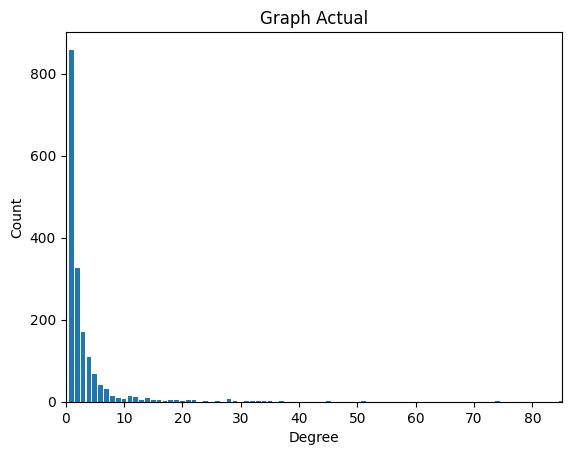

In [10]:
data = graph_df[['source', 'target']]
data = data.to_numpy()
G_true = nx.Graph() #creating the actual(Ground truth) graph from the dataset
for i in range(data.shape[0]):
  G_true.add_edge(data[i][0], data[i][1])
plot_degree_dist(G_true, 'Actual')

In [11]:
cols = graph_df.columns
cols = list(cols)
cols.remove('target')
cols.remove('label')

In [12]:
feature_df = graph_df.loc[:,cols]
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,601,source
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [13]:
X = feature_df.drop("source", axis=1)
cols.remove('source')
X = X.loc[:, cols]
X = X.to_numpy()

In [14]:
#euclidean distance

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

XY = X.sum(1)
D = np.zeros((num_points, num_points), dtype=np.float16)
#D = np.full((num_points, num_points), np.inf)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = XY[start_idx:end_idx]

    # Compute norms for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            if batch_XY[i] == batch_XY[j]:
              idx1, idx2 = find_index(batch_XY[i], batch_XY[j], XY, start_idx, end_idx)
              D[idx1][idx2] = 1.0
              continue
            idx1, idx2 = find_index(batch_XY[i], batch_XY[j], XY, start_idx, end_idx)
            D[idx1][idx2] = np.linalg.norm(batch_XY[i] - batch_XY[j])

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = XY[start_idx:]

    # Compute norms for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            if batch_XY[i] == batch_XY[j]:
              idx1, idx2 = find_index(batch_XY[i], batch_XY[j], XY, start_idx, end_idx)
              D[idx1][idx2] = 1.0
              continue
            idx1, idx2 = find_index(batch_XY[i], batch_XY[j], XY, start_idx, end_idx)
            D[idx1][idx2] = np.linalg.norm(batch_XY[i] - batch_XY[j])

In [15]:
D

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 5., 2.],
       [0., 0., 0., ..., 5., 0., 3.],
       [1., 0., 0., ..., 2., 3., 0.]], dtype=float16)

In [16]:
th = 2.1  # threshold for determining similarity between nodes on the basis of Euclidean distance

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = D[start_idx:end_idx, :]

    # Compare for the current batch
    A[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = D[start_idx:]

    # Compare for the remaining points
    A[start_idx:, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th))

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [17]:
A

<4230x4230 sparse matrix of type '<class 'numpy.bool_'>'
	with 6944 stored elements in Compressed Sparse Row format>

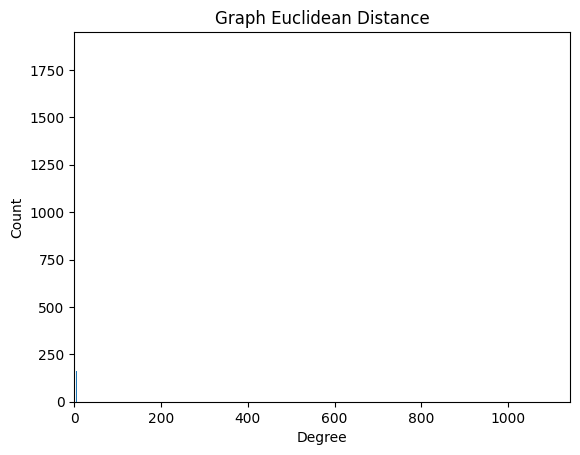

In [18]:
G = nx.Graph(A.toarray())   #predicting graph for Euclidean Distance

plot_degree_dist(G, 'Euclidean Distance')

In [19]:
#cosine similarity

Cos = np.zeros((X.shape[0], X.shape[0]))
#Cos = np.full((num_points, num_points), np.inf)

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]

    # Compute cosine similarities for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = compare_find_common(batch_XY[i,:], batch_XY[j,:], X, start_idx, end_idx)
            Cos[idx1][idx2] = scipy.spatial.distance.cosine(batch_XY[i, :], batch_XY[j, :])*(-1) + 1
            if Cos[idx1][idx2]==0:
              Cos[idx1][idx2]=0.13

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]

    # Compute cosine similarities for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = compare_find_common(batch_XY[i,:], batch_XY[j,:], X, start_idx, end_idx)
            Cos[idx1][idx2] = scipy.spatial.distance.cosine(batch_XY[i, :], batch_XY[j, :])*(-1) + 1
            if Cos[idx1][idx2]==0:
              Cos[idx1][idx2]=0.13

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [20]:
Cos

array([[0.        , 0.13      , 0.13      , ..., 0.        , 0.        ,
        0.        ],
       [0.13      , 0.        , 0.13      , ..., 0.        , 0.        ,
        0.        ],
       [0.13      , 0.13      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.13      ,
        0.13      ],
       [0.        , 0.        , 0.        , ..., 0.13      , 0.        ,
        0.18898225],
       [0.        , 0.        , 0.        , ..., 0.13      , 0.18898225,
        0.        ]])

In [21]:
#compute predicted graph using Cosine Similarity
th1 = 0.415  #threshold for determining similarity between nodes on basis of Cosine Similarity

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A1 = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = Cos[start_idx:end_idx, :]

    # Compare for the current batch
    A1[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th1))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = Cos[start_idx:]

    # Compare for the remaining points
    A1[start_idx:, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th1))

In [22]:
A1

<4230x4230 sparse matrix of type '<class 'numpy.bool_'>'
	with 34524 stored elements in Compressed Sparse Row format>

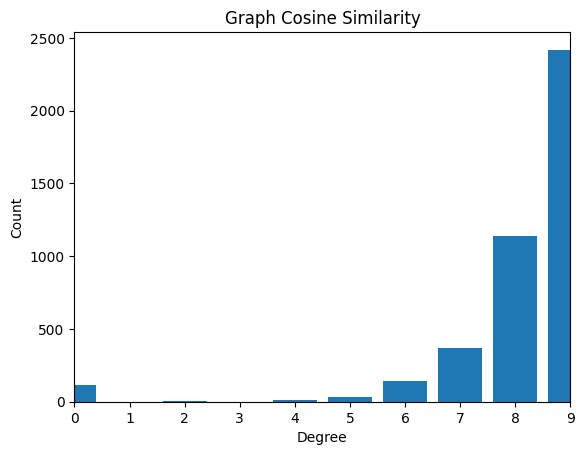

In [23]:
G1 = nx.Graph(A1.toarray())   #predicting graph for Cosine Similarity

plot_degree_dist(G1, 'Cosine Similarity')

In [24]:
#manhattan distance

Man = np.zeros((X.shape[0], X.shape[0]))
#Man = np.full((X.shape[0], X.shape[0]), np.inf)

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]

    # Compute manhattan distances for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = compare_find_common(batch_XY[i,:], batch_XY[j,:], X, start_idx, end_idx)
            Man[idx1][idx2] = sum(np.abs(batch_XY[i, :] - batch_XY[j, :]))
            if Man[idx1][idx2]==0:
              Man[idx1][idx2]=44

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]

    # Compute manhattan distances for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i==j:
                continue
            idx1, idx2 = compare_find_common(batch_XY[i,:], batch_XY[j,:], X, start_idx, end_idx)
            Man[idx1][idx2] = sum(np.abs(batch_XY[i, :] - batch_XY[j, :]))
            if Man[idx1][idx2]==0:
              Man[idx1][idx2]=44

In [25]:
Man

array([[ 0.,  6., 11., ...,  0.,  0.,  0.],
       [ 6.,  0., 11., ...,  0.,  0.,  0.],
       [11., 11.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  9.,  6.],
       [ 0.,  0.,  0., ...,  9.,  0.,  9.],
       [ 0.,  0.,  0., ...,  6.,  9.,  0.]])

In [26]:
#compute predicted graph using Manhattan Distance
th2 = 21  #threshold for determining similarity between nodes on basis of Manhattan Distance

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A2 = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = Man[start_idx:end_idx, :]

    # Compare for the current batch
    A2[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th2))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = Man[start_idx:]

    # Compare for the remaining points
    A2[start_idx:, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th2))

In [27]:
A2

<4230x4230 sparse matrix of type '<class 'numpy.bool_'>'
	with 37420 stored elements in Compressed Sparse Row format>

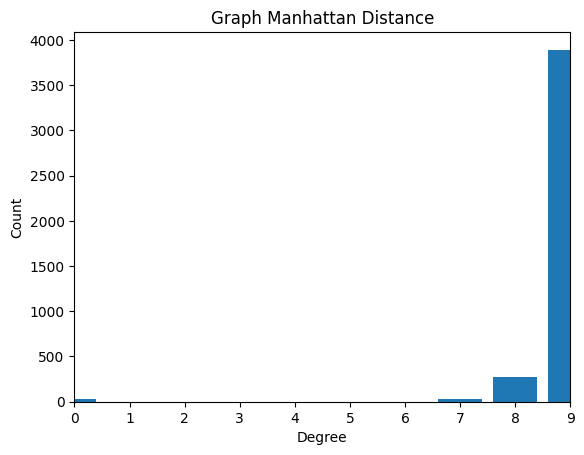

In [28]:
G2 = nx.Graph(A2.toarray())  #predicting graph for Manhattan Distance

plot_degree_dist(G2, 'Manhattan Distance')

In [29]:
#hamming distance can also refer netrd documentation: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.Hamming

thd = 0.6875
batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):   #set binary strings for features of nodes
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]
    X[start_idx:end_idx] = np.where(batch_XY < thd, 1, 0)

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]
    X[start_idx:] = np.where(batch_XY < thd, 1, 0)

In [30]:
#compute hamming distance

Ham = np.zeros((X.shape[0], X.shape[0]))
#Ham = np.full((X.shape[0], X.shape[0]), np.inf)

batch_size = 10  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = X[start_idx:end_idx, :]

    # Compute hamming distance for the current batch
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i == j:
                continue
            idx1, idx2 = compare_find_common(batch_XY[i, :], batch_XY[j, :], Ham, start_idx, end_idx)
            Ham[idx1][idx2] = np.logical_xor(batch_XY[i, :], batch_XY[j, :]).sum()
            if Ham[idx1][idx2]==0:
              Ham[idx1][idx2]=35

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = X[start_idx:]

    # Compute hamming distance for the remaining points
    for i in range(batch_XY.shape[0]):
        for j in range(batch_XY.shape[0]):
            if i == j:
                continue
            idx1, idx2 = compare_find_common(batch_XY[i, :], batch_XY[j, :], Ham, start_idx, end_idx)
            Ham[idx1][idx2] = np.logical_xor(batch_XY[i, :], batch_XY[j, :]).sum()
            if Ham[idx1][idx2]==0:
              Ham[idx1][idx2]=35

In [31]:
Ham

array([[9., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
#compute predicted graph using Hamming Distance
th3 = 11  #threshold for determining similarity between nodes on basis of Hamming Distance

batch_size = 1000  # Define the batch size
num_points = X.shape[0]  # Total number of points
num_batches = num_points // batch_size  # Calculate the number of batches

A3 = csr_matrix((num_points, num_points), dtype=bool)

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_XY = Ham[start_idx:end_idx, :]

    # Compare for the current batch
    A3[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th3))

# Handle the remaining points if the total number of points is not divisible by the batch size
if num_points % batch_size != 0:
    start_idx = num_batches * batch_size
    end_idx = XY.shape[0]
    batch_XY = Ham[start_idx:]

    # Compare for the remaining points
    A3[start_idx:end_idx, :] = csr_matrix(np.logical_and(batch_XY != 0, batch_XY < th3))

In [33]:
A3

<4230x4230 sparse matrix of type '<class 'numpy.bool_'>'
	with 1 stored elements in Compressed Sparse Row format>

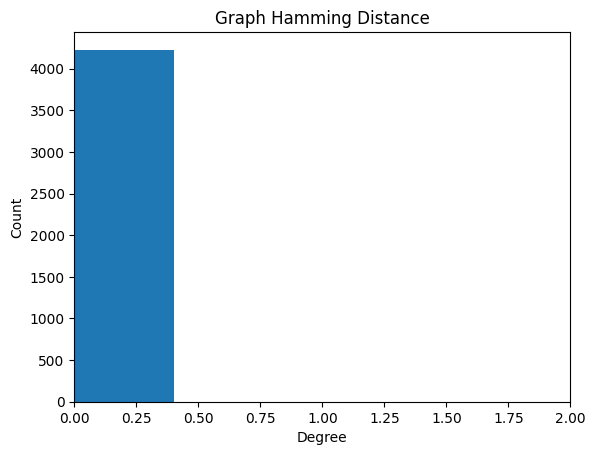

In [34]:
G3 = nx.Graph(A3.toarray())  #predicting graph for Hamming Distance

plot_degree_dist(G3, 'Hamming Distance')

In [35]:
G_true  #actual(Ground truth value) graph estimated from the dataset

In [36]:
#For Jaccard distance refer: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.JaccardDistance

obj = netrd.distance.JaccardDistance()
#corresponding jaccard distance comparsions between predicted and ground truth
y = obj.dist(G, G_true) #euclidean distance
y_1 = obj.dist(G1, G_true) #cosine similarity
y_2 = obj.dist(G2, G_true) #manhattan distance
y_3 = obj.dist(G3, G_true) #hamming distance

print("***Jaccard Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",y)
print("2) Ground truth vs estimated (Cosine):- ",y_1)
print("3) Ground truth vs estimated (Manhattan):- ",y_2)
print("4) Ground truth vs estimated (Hamming):- ",y_3)

l_jacc = [y, y_1, y_2, y_3]

***Jaccard Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  0.9951690821256038
2) Ground truth vs estimated (Cosine):-  0.9917305058089392
3) Ground truth vs estimated (Manhattan):-  0.9898138058464017
4) Ground truth vs estimated (Hamming):-  1.0


In [37]:
#jensen shannon divergence
#*******given below******* link:- https://netrd.readthedocs.io/en/latest/distance.html

#compute js divergence between predicted and groud truth
obj1 = netrd.distance.DegreeDivergence()
jsdy = obj1.dist(G, G_true) #euclidean distance
jsdy_1 = obj1.dist(G1, G_true) #cosine similarity
jsdy_2 = obj1.dist(G2, G_true) #manhattan distance
jsdy_3 = obj1.dist(G3, G_true) #hamming distance

print("***Jensen Shannon Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",jsdy)
print("2) Ground truth vs estimated (Cosine):- ",jsdy_1)
print("3) Ground truth vs estimated (Manhattan):- ",jsdy_2)
print("4) Ground truth vs estimated (Hamming):- ",jsdy_3)

l_js = [jsdy, jsdy_1, jsdy_2, jsdy_3]

***Jensen Shannon Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  0.5042657894032442
2) Ground truth vs estimated (Cosine):-  0.9929468233837426
3) Ground truth vs estimated (Manhattan):-  1.0845059256322676
4) Ground truth vs estimated (Hamming):-  1.1403036715569186


In [38]:
#graph node signature distribution similarity
#reference: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.NetSimile

obj2 = netrd.distance.NetSimile()
nsy = obj2.dist(G, G_true) #euclidean distance
nsy_1 = obj2.dist(G1, G_true) #cosine similarity
nsy_2 = obj2.dist(G2, G_true) #manhattan distance
nsy_3 = obj2.dist(G3, G_true) #hamming distance

print("***Graph Node Signature Distribution Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",nsy)
print("2) Ground truth vs estimated (Cosine):- ",nsy_1)
print("3) Ground truth vs estimated (Manhattan):- ",nsy_2)
print("4) Ground truth vs estimated (Hamming):- ",nsy_3)

l_ns = [nsy, nsy_1, nsy_2, nsy_3]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


***Graph Node Signature Distribution Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  20.88047903643012
2) Ground truth vs estimated (Cosine):-  23.648919798679533
3) Ground truth vs estimated (Manhattan):-  26.98290863046821
4) Ground truth vs estimated (Hamming):-  23.443174933749308


In [39]:
#Onion distance between graphs based on their adjacency matrices
#reference: https://netrd.readthedocs.io/en/latest/distance.html#netrd.distance.OnionDivergence

obj3 = netrd.distance.OnionDivergence()
froby = obj3.dist(G, G_true) #euclidean distance
froby_1 = obj3.dist(G1, G_true) #cosine similarity
froby_2 = obj3.dist(G2, G_true) #manhattan distance
froby_3 = obj3.dist(G3, G_true) #hamming distance

print("***Onion Distance Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ",froby)
print("2) Ground truth vs estimated (Cosine):- ",froby_1)
print("3) Ground truth vs estimated (Manhattan):- ",froby_2)
print("4) Ground truth vs estimated (Hamming):- ",froby_3)

l_frob = [froby, froby_1, froby_2, froby_3]

***Onion Distance Similarity Summary***
1) Ground truth vs estimated (Euclidean):-  0.8313273524583568
2) Ground truth vs estimated (Cosine):-  0.9974692512058732
3) Ground truth vs estimated (Manhattan):-  0.9999999999999827
4) Ground truth vs estimated (Hamming):-  0.49999999999998884


In [40]:
m1 = max(l_jacc)
m2 = min(l_js)
m3 = max(l_ns)
m4 = min(l_frob)
l1 = find_index(m1, None, l_jacc, 0, 4)
l2 = find_index(m2, None, l_js, 0, 4)
l3 = find_index(m3, None, l_ns, 0, 4)
l4 = find_index(m4, None, l_frob, 0, 4)
i = convert(l1[0])  #closer graph metric as per Jaccard similarity
j = convert(l2[0])  #closer graph metric as per JS divergence similarity
k = convert(l3[0])  #closer graph metric as per Node Signature similarity
l = convert(l4[0])  #closer graph metric as per Onion Degree Divergence similarity

Hamming Distance
Euclidean Distance
Manhattan Distance
Hamming Distance


In [41]:
'''
TODO1 : Till the work done above, summarise all your readings and observations for
each dataset in the form of a table. Justify them using values obtained
(5 tables for 5 datasets)

TODO2: For each dataset, generate its descriptive statistics (number of nodes,
number of node features, etc) (5 tables for 5 datasets)
'''

'\nTODO1 : Till the work done above, summarise all your readings and observations for\neach dataset in the form of a table. Justify them using values obtained\n(5 tables for 5 datasets)\n\nTODO2: For each dataset, generate its descriptive statistics (number of nodes,\nnumber of node features, etc) (5 tables for 5 datasets)\n'

In [42]:
report = pd.DataFrame(index = ['Euclidean Distance', 'Cosine Similarity', 'Manhattan Distance', 'Hamming Distance'])
report['Jaccard Distance'] = l_jacc
report['JS Divergence'] = l_js
report['Netsimile Divergence'] = l_ns
report['Onion Divergence'] = l_frob
report['Threshold Value'] = [th, th1, th2, th3]
report['Hamming Threshold'] = [0, 0, 0, thd]

final_results = pd.DataFrame(index = ['Euclidean Distance', 'Cosine Similarity', 'Manhattan Distance', 'Hamming Distance'])
final_results['Jaccard Distance'] = ['Not Close: {}'.format(l_jacc[0]), 'Not Close: {}'.format(l_jacc[1]), 'Not Close: {}'.format(l_jacc[2]), 'Not Close: {}'.format(l_jacc[3])]
final_results['JS Divergence'] = ['Not Close: {}'.format(l_js[0]), 'Not Close: {}'.format(l_js[1]), 'Not Close: {}'.format(l_js[2]), 'Not Close: {}'.format(l_js[3])]
final_results['Netsimile Divergence'] = ['Not Close: {}'.format(l_ns[0]), 'Not Close: {}'.format(l_ns[1]), 'Not Close: {}'.format(l_ns[2]), 'Not Close: {}'.format(l_ns[3])]
final_results['Onion Divergence'] = ['Not Close: {}'.format(l_frob[0]), 'Not Close: {}'.format(l_frob[1]), 'Not Close: {}'.format(l_frob[2]), 'Not Close: {}'.format(l_frob[3])]
final_results['Jaccard Distance'][i] = 'Close: {}'.format(m1)
final_results['JS Divergence'][j] = 'Close: {}'.format(m2)
final_results['Netsimile Divergence'][k] = 'Close: {}'.format(m3)
final_results['Onion Divergence'][l] = 'Close: {}'.format(m4)


In [43]:
report #printing report

,Jaccard Distance,JS Divergence,Netsimile Divergence,Onion Divergence,Threshold Value,Hamming Threshold
Euclidean Distance,0.995169,0.504266,20.880479,0.831327,2.100,0.0000
Cosine Similarity,0.991731,0.992947,23.648920,0.997469,0.415,0.0000
Manhattan Distance,0.989814,1.084506,26.982909,1.000000,21.000,0.0000
Hamming Distance,1.000000,1.140304,23.443175,0.500000,11.000,0.6875


In [44]:
final_results #printing final observations

,Jaccard Distance,JS Divergence,Netsimile Divergence,Onion Divergence
Euclidean Distance,Not Close: 0.9951690821256038,Close: 0.5042657894032442,Not Close: 20.88047903643012,Not Close: 0.8313273524583568
Cosine Similarity,Not Close: 0.9917305058089392,Not Close: 0.9929468233837426,Not Close: 23.648919798679533,Not Close: 0.9974692512058732
Manhattan Distance,Not Close: 0.9898138058464017,Not Close: 1.0845059256322676,Close: 26.98290863046821,Not Close: 0.9999999999999827
Hamming Distance,Close: 1.0,Not Close: 1.1403036715569186,Not Close: 23.443174933749308,Close: 0.49999999999998884


In [45]:
#creating csv files
report.to_csv("report_"+s+".csv")
final_results.to_csv("final_results_"+s+".csv")

In [46]:
#zipping together csv files
import zipfile as zp

with zp.ZipFile("table_"+s+".zip",'w') as zipf:
  zipf.write("report_"+s+".csv")
  zipf.write("final_results_"+s+".csv")
  zipf.write("dataset_report_"+s+".csv")

In [ ]:
A_true = nx.adjacency_matrix(G_true).toarray() #compute adjacency matrix for ground truth analysis
#type(A_true) #check whther A_true is numpy matrix or not

In [ ]:
#compute kl divergence between predicted and actual graphs
#add make-equal function

chunk_size = 500  # Adjust the chunk size based on the size of A
A = nx.adjacency_matrix(G).toarray()
A1 = nx.adjacency_matrix(G1).toarray()
A2 = nx.adjacency_matrix(G2).toarray()
A3 = nx.adjacency_matrix(G3).toarray()

num_chunks = len(A) // chunk_size
remainder = len(A) % chunk_size

kly, kly_1, kly_2, kly_3 = 0, 0, 0, 0

# Calculate KL divergence for each chunk for each case
for i in range(num_chunks):
    start = i * chunk_size
    end = (i + 1) * chunk_size
    kly += make_compatible_kl(A[start:end], A_true[start:end])
    kly_1 += make_compatible_kl(A1[start:end], A_true[start:end]).sum()
    kly_2 += make_compatible_kl(A2[start:end], A_true[start:end]).sum()
    kly_3 += make_compatible_kl(A3[start:end], A_true[start:end]).sum()

# Calculate KL divergence for the remaining elements
if remainder > 0:
    kly += make_compatible_kl(A[-remainder:], A_true[-remainder:]).sum()
    kly_1 += make_compatible_kl(A1[-remainder:], A_true[-remainder:]).sum()
    kly_2 += make_compatible_kl(A2[-remainder:], A_true[-remainder:]).sum()
    kly_3 += make_compatible_kl(A3[-remainder:], A_true[-remainder:]).sum()

print("***KL Divergence Similarity Summary***")
print("1) Ground truth vs estimated (Euclidean):- ", kly)
print("2) Ground truth vs estimated (Cosine):- ", kly_1)
print("3) Ground truth vs estimated (Manhattan):- ", kly_2)
print("4) Ground truth vs estimated (Hamming):- ", kly_3)

l_kl = [kly, kly_1, kly_2, kly_3]

In [ ]:
m3 = min(l_kl)  #closer graph metric as per KL divergence
l3 = find_index(m3, None, l_kl, 0, 4)
convert(l3[0])

Hamming


In [ ]:
#implement Wasserstein, Dice and mahalanobis distances
#TODO: YOUR CODE HERE

In [ ]:
#**********Rough work below***************
'''
kbfwjbgwkbikfbukebgkelwfn
ewbjeikqbibjbigjgkjwbggf
ffgfjgkbwkgbjgkbgjgbkjkgbjgqkgj
gjbeqikbjgkqbgjkgbqjkbjgqkqhufihquighikb
'''

In [ ]:
# path1 = '/content/drive/MyDrive/Colab Notebooks/Summer training/network0_weighted.csv'
# path2 = '/content/drive/MyDrive/Colab Notebooks/Summer training/power-494-bus.mtx'
# path3 = '/content/drive/MyDrive/Colab Notebooks/Summer training/inf-euroroad.edges'
# path4 = '/content/drive/MyDrive/Colab Notebooks/Summer training/email-dnc-corecipient.edges'
# path5 = '/content/drive/MyDrive/Colab Notebooks/Summer training/econ-mahindas.mtx'

In [ ]:
#DONE: Add Wasserstein distribution distance metric here refer:- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
#Your code here
ws1 = scipy.stats.wasserstein_distance(sum(X5,1), sum(X3,1))
ws2 = scipy.stats.wasserstein_distance(sum(X3,1), sum(X5,1))
ws1 == ws2   #shows Wasserstein distance metric is symmetric in nature

True

In [ ]:
ws1 #Wasserstein distance between graph5 and graph3

12.801347491995376

In [ ]:
#DONE: Try adding Dice similarity metric also refer:- https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.dice.html
#Your code here

def make_equal_compute_dice(arr1, arr2):    #dice loss requires 1D arrays of equal size. To make arrays of same size, I created a function
  if arr1.shape[0]>arr2.shape[0]:
    arr3 = np.zeros(arr1.shape[0])
    for i in range(arr2.shape[0]):
      arr3[i] = arr2[i]
    dc = scipy.spatial.distance.dice(arr1, arr3)
    return dc
  elif arr1.shape[0]<arr2.shape[0]:
    arr3 = np.zeros(arr2.shape[0])
    for i in range(arr1.shape[0]):
      arr3[i] = arr1[i]
    dc = scipy.spatial.distance.dice(arr3, arr2)
    return dc
  else:
    dc = scipy.spatial.distance.dice(arr1, arr2)
    return dc

dc1 = make_equal_compute_dice(sum(X1,1),sum(X3,1))
dc2 = make_equal_compute_dice(sum(X3,1),sum(X1,1))
print(dc1 == dc2)   #shows whther dice similarity is symmetric or not
print(dc1)  #dice similarity between graphs 1 and 3

True
0.8015753115124495


In [ ]:
#DONE: Try adding Mahalanobis distance metric also
#Your code here

def make_equal_compute_mahalanobis_dist(arr1, arr2):   #requires a covariance matrix of order compatible with the input arrays being compared
  if arr1.shape[0]>arr2.shape[0]:
    arr3 = np.zeros(arr1.shape[0])
    for i in range(arr2.shape[0]):
      arr3[i] = arr2[i]
    cov = np.cov(arr1, arr3)
    cvi = np.linalg.inv(cov)
    c = np.zeros((arr1.shape[0],arr1.shape[0]))
    for i in range(cvi.shape[0]):
      for j in range(cvi.shape[1]):
        c[i][j] = cvi[i][j]
    mnl = scipy.spatial.distance.mahalanobis(arr1, arr3, c)
    return mnl
  elif arr1.shape[0]<arr2.shape[0]:
    arr3 = np.zeros(arr2.shape[0])
    for i in range(arr1.shape[0]):
      arr3[i] = arr1[i]
    cov = np.cov(arr3, arr2)
    cvi = np.linalg.inv(cov)
    c = np.zeros((arr2.shape[0],arr2.shape[0]))
    for i in range(cvi.shape[0]):
      for j in range(cvi.shape[1]):
        c[i][j] = cvi[i][j]
    mnl = scipy.spatial.distance.mahalanobis(arr3, arr2, c)
    return mnl
  else:
    cov = np.cov(arr1, arr2)
    cvi = np.linalg.inv(cov)
    c = np.zeros((arr2.shape[0],arr2.shape[0]))
    for i in range(cvi.shape[0]):
      for j in range(cvi.shape[1]):
        c[i][j] = cvi[i][j]
    mnl = scipy.spatial.distance.mahalanobis(arr1, arr2, c)
    return mnl

mnla = make_equal_compute_mahalanobis_dist(sum(X2,1), sum(X4,1))
mnlb = make_equal_compute_mahalanobis_dist(sum(X4,1), sum(X2,1))

mnla == mnlb #shows the symmetric nature of mahalanobis distance
#*******Calculation may not be done properly as I was unsure on how to remove errors*******

False

In [ ]:
mnlb

2.9451250072210517

In [ ]:
mnla

3.9773626913489046